In [26]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [27]:
data = sio.loadmat('/Users/ramil.grv/Desktop/FB_20141126.mat')

In [28]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

In [29]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

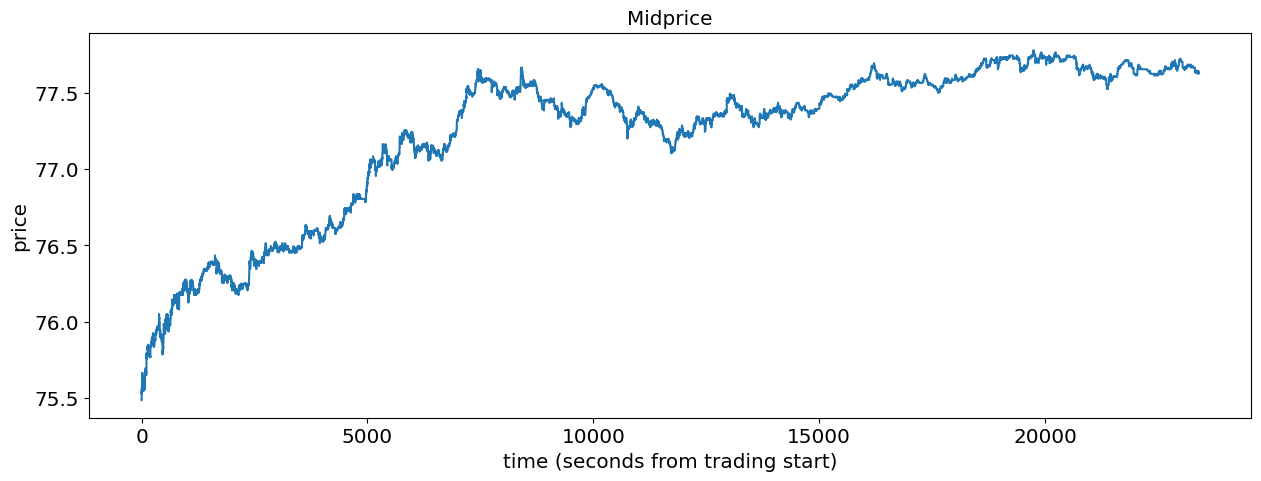

In [30]:
plt.plot(t, midprice)
plt.title('Midprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

In [31]:
type(midprice)


numpy.ndarray

In [32]:
import pandas as pd

In [33]:
midp = pd.DataFrame(midprice)

In [34]:
midp.describe()

,0
count,234000.000000
mean,77.237420
std,0.497852
min,75.485000
25%,77.105000
50%,77.405000
75%,77.595000
max,77.780000


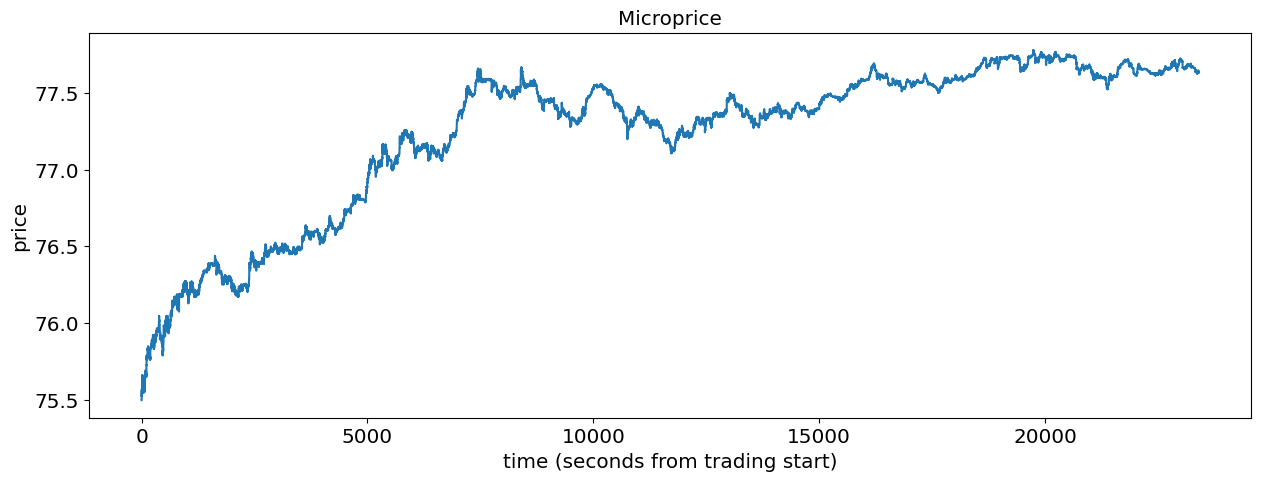

In [35]:
plt.plot(t, microprice)
plt.title('Microprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

In [36]:
microp = pd.DataFrame(microprice)

In [37]:
microp.describe()

,0
count,234000.000000
mean,77.237172
std,0.497735
min,75.498152
25%,77.108171
50%,77.403333
75%,77.590193
max,77.776842


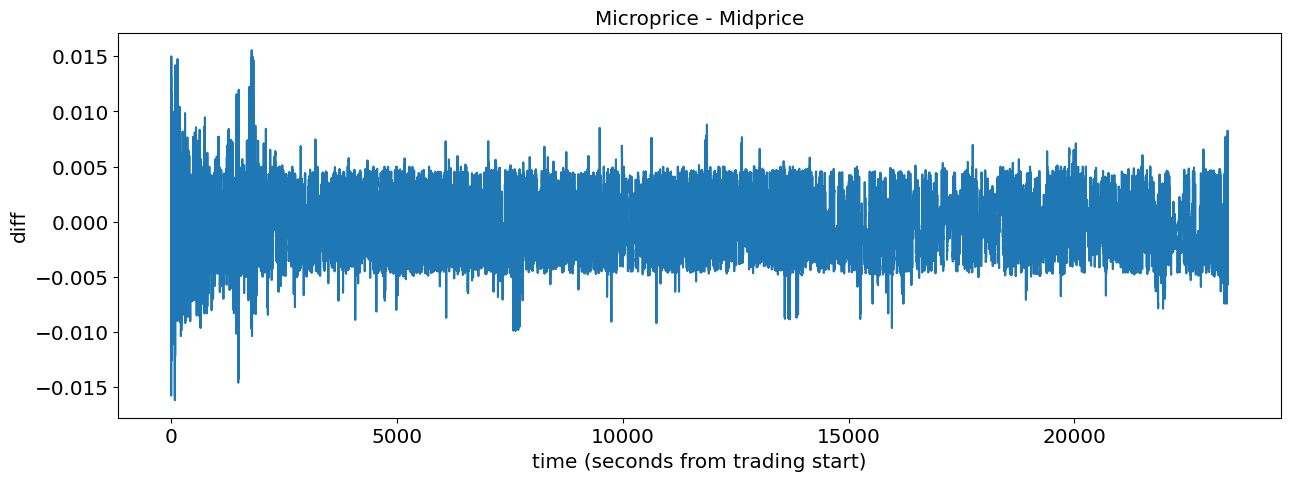

In [38]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

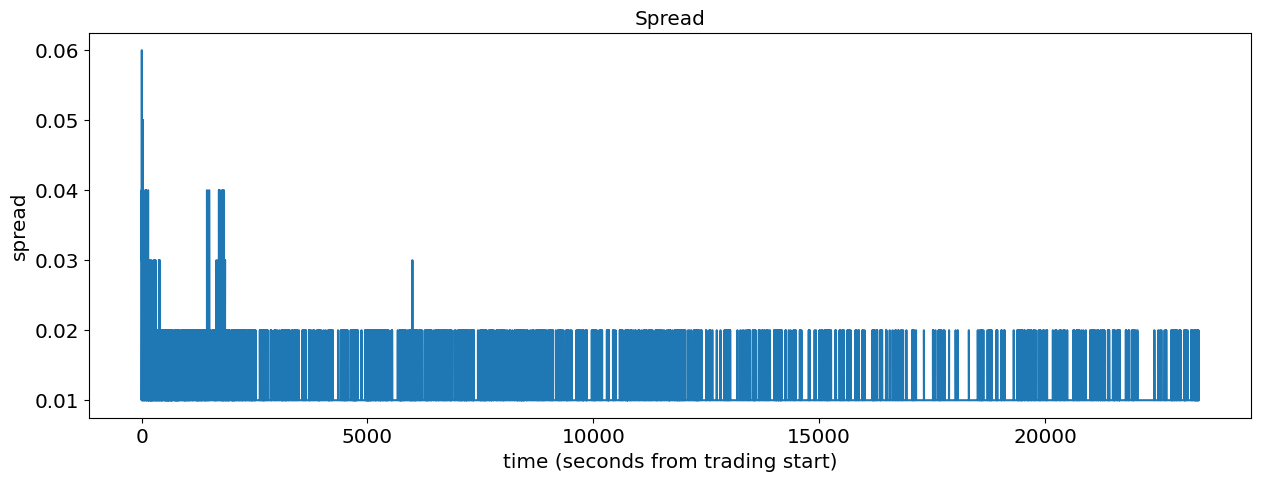

spread: 0.01


In [39]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.show()
print(f"spread: {np.mean(spread):.2f}")

In [40]:
spread = pd.DataFrame(spread)

In [41]:
spread.describe()

,0
count,234000.000000
mean,0.010736
std,0.002859
min,0.010000
25%,0.010000
50%,0.010000
75%,0.010000
max,0.060000


In [42]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

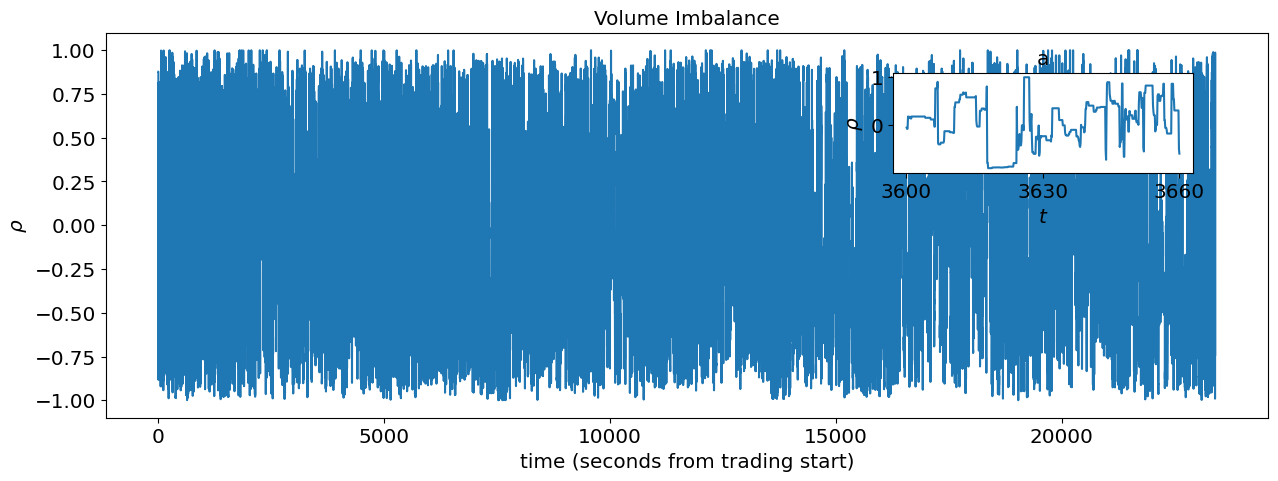

In [43]:
plt.plot(t, rho)
plt.title('Volume Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()


In [44]:
rho = pd.DataFrame(rho)

In [45]:
rho.describe()

,0
count,234000.000000
mean,-0.049366
std,0.489329
min,-0.999328
25%,-0.436778
50%,-0.062500
75%,0.331558
max,0.999498


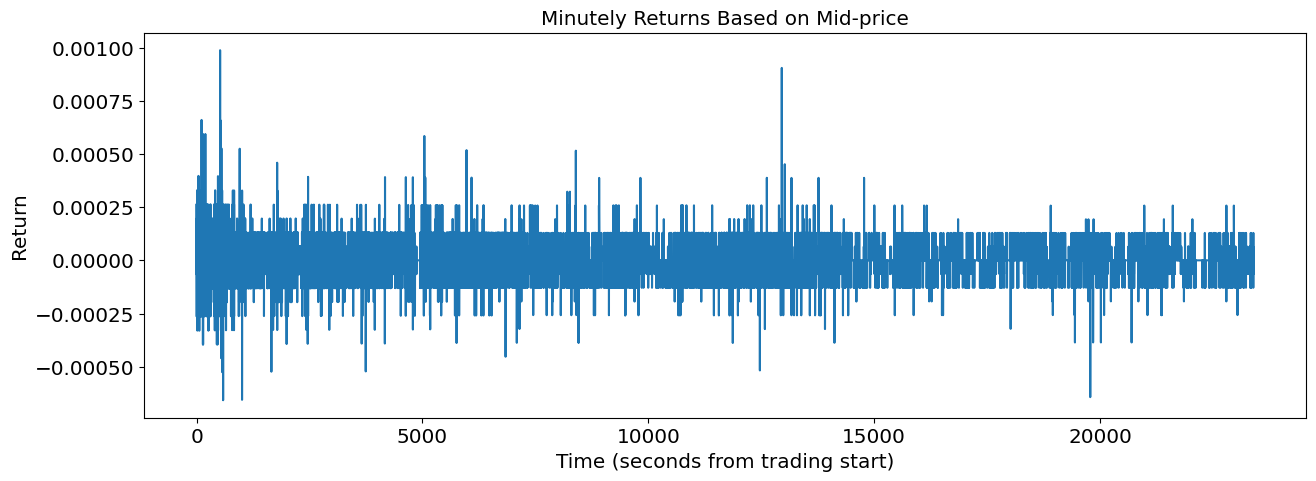

       Minutely Returns
count      2.339990e+05
mean       1.202627e-07
std        2.206539e-05
min       -6.576784e-04
25%        0.000000e+00
50%        0.000000e+00
75%        0.000000e+00
max        9.878820e-04


In [46]:
# Calculate minutely returns based on mid-price
midprice_returns = midprice[1:] / midprice[:-1] - 1

# Insert NaN as the first element since there is no return for the first observation
midprice_returns = np.insert(midprice_returns, 0, np.nan)

# Plot the returns
plt.plot(t, midprice_returns)
plt.title('Minutely Returns Based on Mid-price')
plt.ylabel('Return')
plt.xlabel('Time (seconds from trading start)')
plt.show()

# Display summary statistics of the returns
returns_df = pd.DataFrame(midprice_returns, columns=['Minutely Returns'])
returns_summary = returns_df.describe()
print(returns_summary)


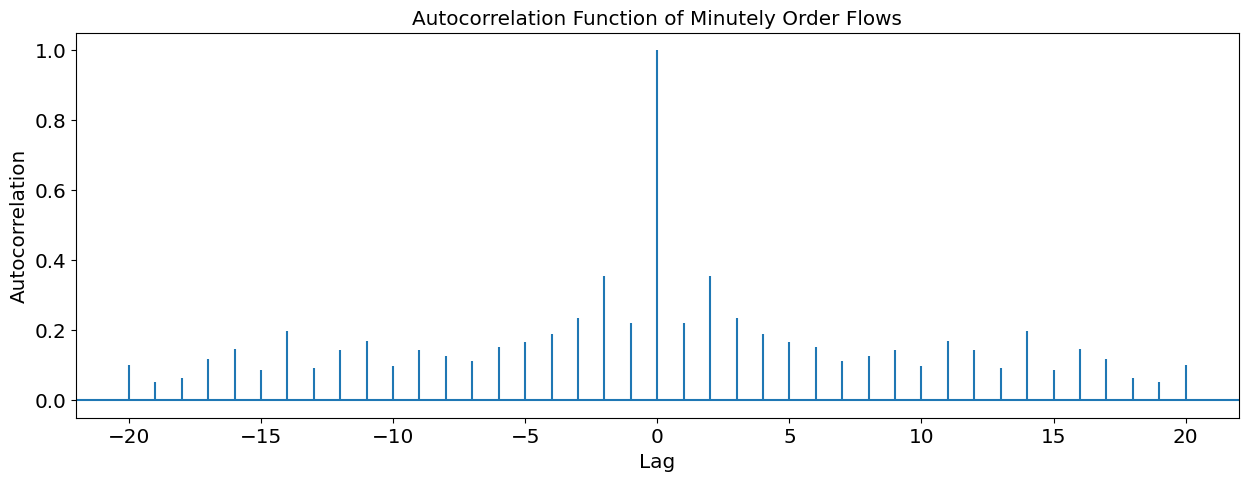

In [49]:
# Calculate minutely order flows (net MO within each minute)
order_flow = np.diff(MO[:, 0])  # Assuming MO has shape (num_samples, 1)

# Calculate the autocorrelation function (ACF) up to 20 lags
lags = 20
acf_order_flow = np.correlate(order_flow, order_flow, mode='full')
acf_order_flow = acf_order_flow / np.max(acf_order_flow)  # Normalize ACF values

# Plot the ACF of order flows
plt.acorr(order_flow, maxlags=lags)
plt.title('Autocorrelation Function of Minutely Order Flows')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


In [53]:
import statsmodels.api as sm

# Calculate minutely returns based on mid-price
midprice_returns = midprice[1:] / midprice[:-1] - 1
midprice_returns = np.insert(midprice_returns, 0, np.nan)

# Calculate minutely order flows (net MO within each minute)
order_flow = np.diff(MO[:, 0])  # Assuming MO has shape (num_samples, 1)

# Create a lagged return variable
lagged_return = np.roll(midprice_returns, 1)
lagged_return[0] = np.nan  # Set the first value to NaN since there is no lagged return for the first observation

# Make sure all arrays have the same length
min_length = min(len(lagged_return), len(order_flow), len(midprice_returns))
lagged_return = lagged_return[:min_length]
order_flow = order_flow[:min_length]
midprice_returns = midprice_returns[:min_length]

# Create a DataFrame with the variables
regression_data = pd.DataFrame({
    'Lagged_Return': lagged_return,
    'Order_Flow': order_flow,
    'Minutely_Return': midprice_returns
})

# Drop rows with missing values
regression_data = regression_data.dropna()

# Perform linear regression
X = sm.add_constant(regression_data[['Lagged_Return', 'Order_Flow']])
y = regression_data['Minutely_Return']
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:        Minutely_Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.746
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           0.000434
Time:                        06:28:01   Log-Likelihood:             1.5304e+05
No. Observations:               17616   AIC:                        -3.061e+05
Df Residuals:                   17613   BIC:                        -3.060e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.613e-07   3.08e-07      1.820

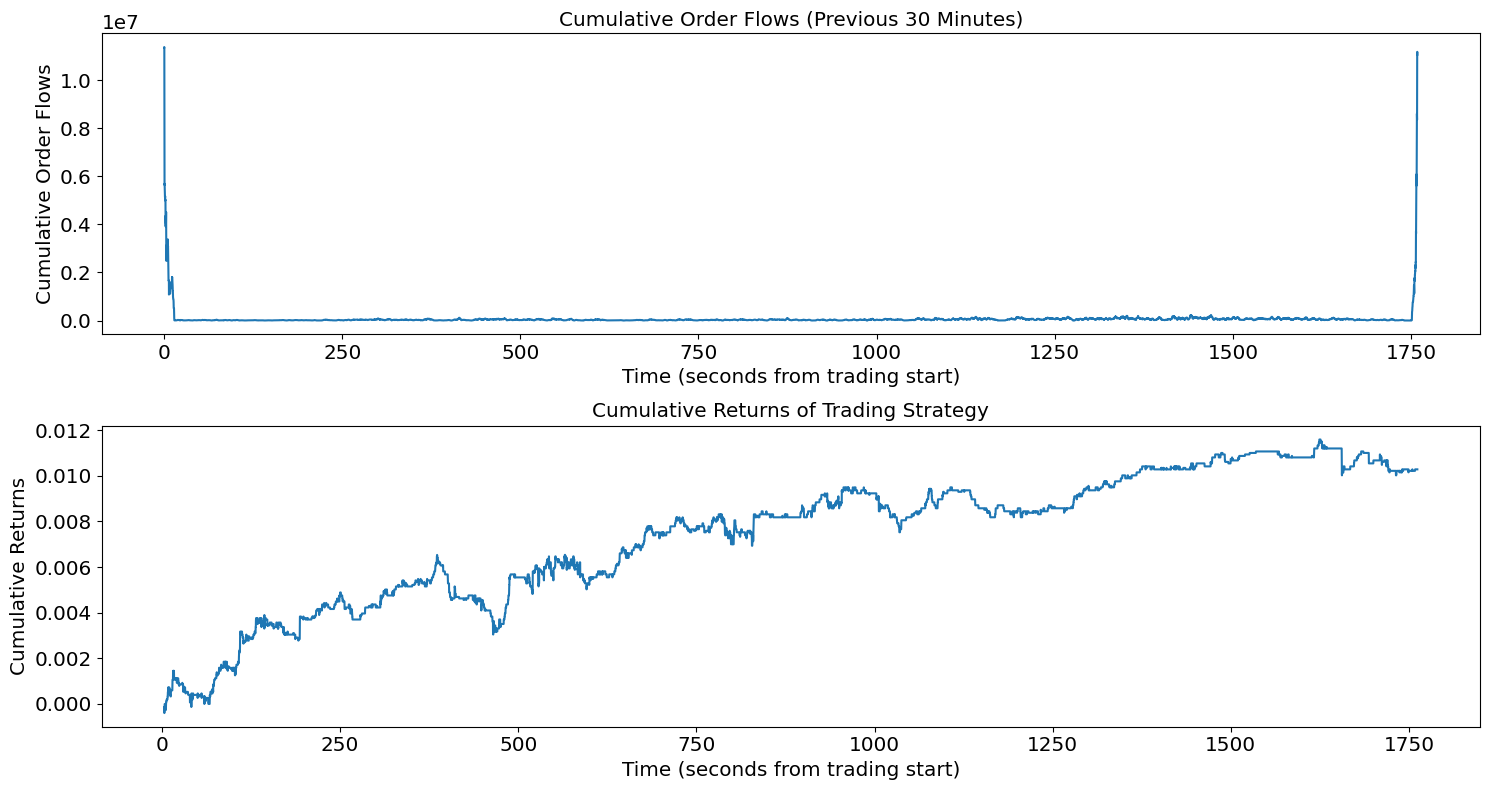

In [59]:
# Adjust the range of t for cumulative_returns to match the length of cumulative_returns
t_range_returns = t[30:30 + len(cumulative_returns)]

# Plot cumulative order flows and trading signals
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(t_range, cumulative_order_flows)
plt.title('Cumulative Order Flows (Previous 30 Minutes)')
plt.xlabel('Time (seconds from trading start)')
plt.ylabel('Cumulative Order Flows')

plt.subplot(2, 1, 2)
plt.plot(t_range_returns, cumulative_returns)
plt.title('Cumulative Returns of Trading Strategy')
plt.xlabel('Time (seconds from trading start)')
plt.ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()



In [64]:
# Replace midprice with the actual variable representing the stock's prices
# Calculate total return for the stock
total_stock_return = (midprice[-1] - midprice[0]) / midprice[0]

# Calculate total return for the trading strategy
total_strategy_return = cumulative_returns[-1]

# Compare the returns
print(f"Total Return of Trading Strategy: {total_strategy_return:.4f}")
print(f"Total Return of Stock: {total_stock_return:.4f}")

# Analyze the performance
if total_strategy_return > total_stock_return:
    print("The trading strategy outperformed the stock.")
elif total_strategy_return < total_stock_return:
    print("The trading strategy underperformed the stock.")
else:
    print("The trading strategy and stock had similar returns.")


Total Return of Trading Strategy: 0.0103
Total Return of Stock: 0.0285
The trading strategy underperformed the stock.
